In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/janatahack-crosssell-prediction/sample_submission_iA3afxn.csv
/kaggle/input/janatahack-crosssell-prediction/test.csv
/kaggle/input/janatahack-crosssell-prediction/train.csv


In [2]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold,KFold,GroupKFold
import time
%matplotlib inline

In [3]:
# to see all the comands result in a single kernal 
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
# to increase no. of rows and column visibility in outputs
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
#reading data
train=pd.read_csv("../input/janatahack-crosssell-prediction/train.csv")
test=pd.read_csv("../input/janatahack-crosssell-prediction/test.csv")
sub=pd.read_csv('../input/janatahack-crosssell-prediction/sample_submission_iA3afxn.csv')
train.shape
test.shape
sub.shape

(381109, 12)

(127037, 11)

(127037, 2)

Basic Visualization

In [6]:
train.head()

id  Gender  Age  Driving_License  Region_Code  Previously_Insured Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  Response
0   1    Male   44                1         28.0                   0   > 2 Years            Yes         40454.0                  26.0      217         1
1   2    Male   76                1          3.0                   0    1-2 Year             No         33536.0                  26.0      183         0
2   3    Male   47                1         28.0                   0   > 2 Years            Yes         38294.0                  26.0       27         1
3   4    Male   21                1         11.0                   1    < 1 Year             No         28619.0                 152.0      203         0
4   5  Female   29                1         41.0                   1    < 1 Year             No         27496.0                 152.0       39         0

In [7]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 

In [8]:
train.describe()
test.describe()

id            Age  Driving_License    Region_Code  Previously_Insured  Annual_Premium  Policy_Sales_Channel        Vintage       Response
count  381109.000000  381109.000000    381109.000000  381109.000000       381109.000000   381109.000000         381109.000000  381109.000000  381109.000000
mean   190555.000000      38.822584         0.997869      26.388807            0.458210    30564.389581            112.034295     154.347397       0.122563
std    110016.836208      15.511611         0.046110      13.229888            0.498251    17213.155057             54.203995      83.671304       0.327936
min         1.000000      20.000000         0.000000       0.000000            0.000000     2630.000000              1.000000      10.000000       0.000000
25%     95278.000000      25.000000         1.000000      15.000000            0.000000    24405.000000             29.000000      82.000000       0.000000
50%    190555.000000      36.000000         1.000000      28.000000            0.000000    31669.000000            133.000000     154.000000       0.000000
75%    285832.000000      49.000000         1.000000      35.000000            1.000000    39400.000000            152.000000     227.000000       0.000000
max    381109.000000      85.000000         1.000000      52.000000            1.000000   540165.000000            163.000000     299.000000       1.000000

id            Age  Driving_License    Region_Code  Previously_Insured  Annual_Premium  Policy_Sales_Channel        Vintage
count  127037.000000  127037.000000    127037.000000  127037.000000       127037.000000   127037.000000         127037.000000  127037.000000
mean   444628.000000      38.765903         0.998134      26.459866            0.460039    30524.643576            111.800468     154.318301
std     36672.567411      15.465814         0.043152      13.209916            0.498403    16945.297103             54.371765      83.661588
min    381110.000000      20.000000         0.000000       0.000000            0.000000     2630.000000              1.000000      10.000000
25%    412869.000000      25.000000         1.000000      15.000000            0.000000    24325.000000             26.000000      82.000000
50%    444628.000000      36.000000         1.000000      28.000000            0.000000    31642.000000            135.000000     154.000000
75%    476387.000000      49.000000         1.000000      35.000000            1.000000    39408.000000            152.000000     227.000000
max    508146.000000      85.000000         1.000000      52.000000            1.000000   472042.000000            163.000000     299.000000

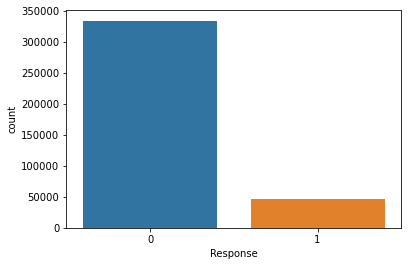

In [9]:
sns.countplot(train['Response']);

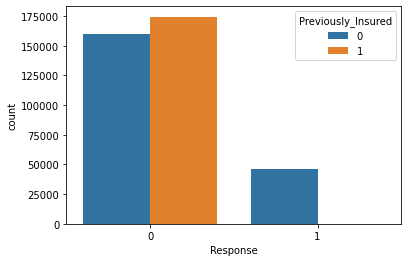

In [10]:
sns.countplot(train['Response'],hue=train['Previously_Insured']);

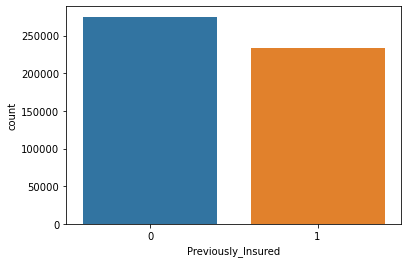

In [11]:
sns.countplot(pd.concat([train['Previously_Insured'],test['Previously_Insured']],axis=0));

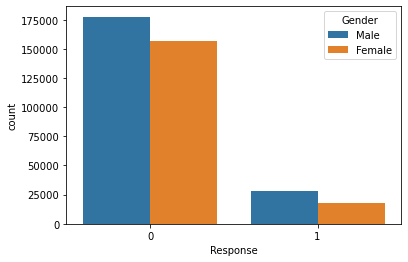

In [12]:
sns.countplot(train['Response'],hue=train['Gender']);

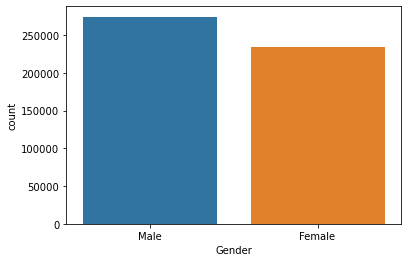

In [13]:
sns.countplot(pd.concat([train['Gender'],test['Gender']],axis=0));

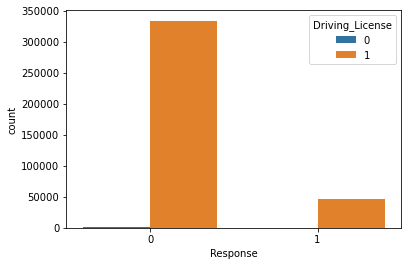

In [14]:
sns.countplot(train['Response'],hue=train['Driving_License']);

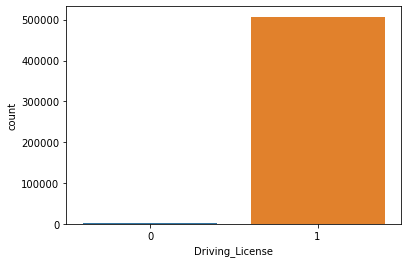

In [15]:
sns.countplot(pd.concat([train['Driving_License'],test['Driving_License']],axis=0));

In [16]:
len(train[train['Driving_License']==0])/len(train)

0.0021306240471885996

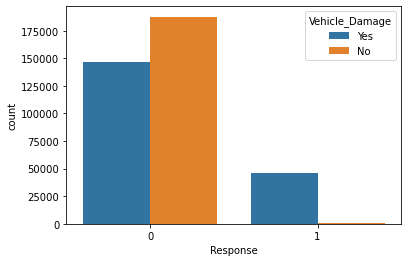

In [17]:
sns.countplot(train['Response'],hue=train['Vehicle_Damage']);

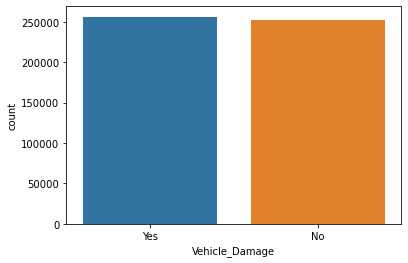

In [18]:
sns.countplot(pd.concat([train['Vehicle_Damage'],test['Vehicle_Damage']],axis=0));

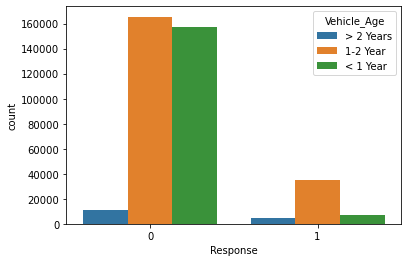

In [19]:
sns.countplot(train['Response'],hue=train['Vehicle_Age']);

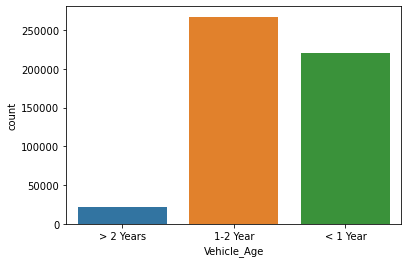

In [20]:
sns.countplot(pd.concat([train['Vehicle_Age'],test['Vehicle_Age']],axis=0));

In [21]:
train['id'].nunique()
test['id'].nunique()

381109

127037

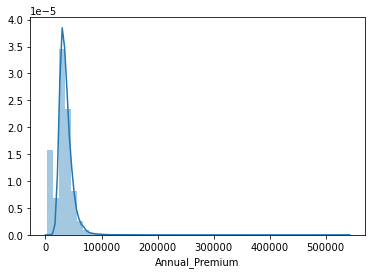

In [22]:
sns.distplot(train['Annual_Premium']);

Pre-processing

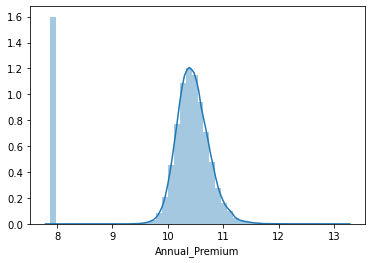

In [23]:
#Data is left Skewed as we can see from above distplot
train['Annual_Premium']=np.log1p(train['Annual_Premium'])
sns.distplot(train['Annual_Premium']);

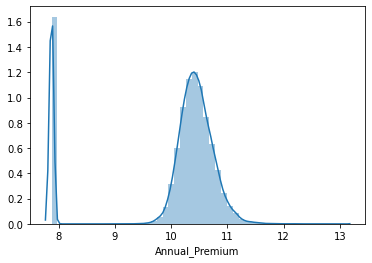

In [24]:
test['Annual_Premium']=np.log1p(test['Annual_Premium'])
sns.distplot(test['Annual_Premium']);

In [25]:
# Missing Values
train.isnull().sum().sum()
test.isnull().sum().sum()

0

0

In [26]:
cat_cols=['Driving_License','Gender','Policy_Sales_Channel','Previously_Insured','Region_Code','Vehicle_Age','Vehicle_Damage']

In [27]:
#converting categorical features to numerical features
train['Gender']=train['Gender'].replace({'Male':1,'Female':0})
train['Vehicle_Damage']=train['Vehicle_Damage'].replace({'Yes':1,'No':0})
train['Vehicle_Age']=train['Vehicle_Age'].replace({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})
test['Gender']=test['Gender'].replace({'Male':1,'Female':0})
test['Vehicle_Damage']=test['Vehicle_Damage'].replace({'Yes':1,'No':0})
test['Vehicle_Age']=test['Vehicle_Age'].replace({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})

In [28]:
test_id=test['id']

In [29]:
train=train.drop(columns=['id'],axis=1)
test=test.drop(columns=['id'],axis=1)
#cat_cols=['Gender','Policy_Sales_Channel','Previously_Insured','Region_Code','Vehicle_Age','Vehicle_Damage']

In [30]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 32.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127037 entries, 0 to 127036
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  

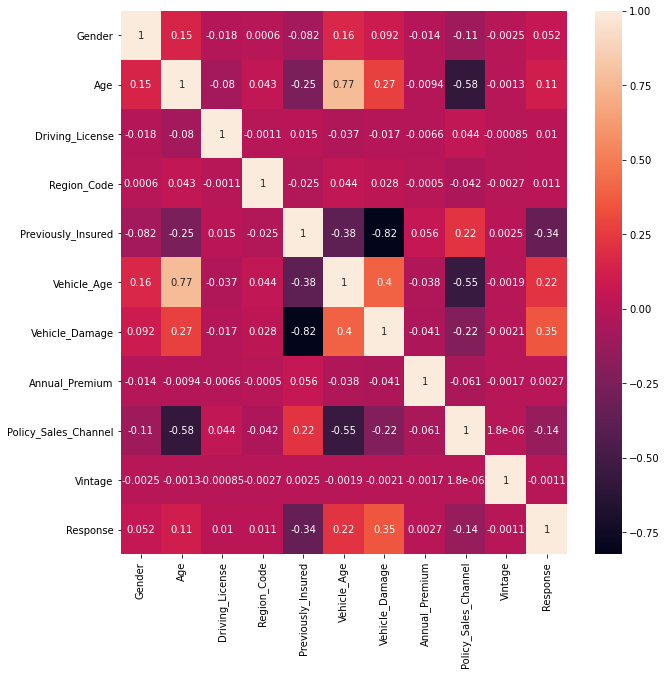

In [31]:
#Checking correlation between features
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(),annot=True);

In [32]:
#creating X and y for training
y=train['Response']
X=train.drop(columns='Response',axis=1)

In [33]:
len(test)/(len(test)+len(train))

0.2500009839691742

In [34]:
X_tr,X_te,y_tr,y_te=train_test_split(X,y,random_state=0,test_size=0.25,stratify=y,shuffle=True)

In [35]:
#lgbm stratified k-fold
#%%time
err = [] 
y_pred_tot_lgbm = np.zeros((len(test), 2))


fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
i = 1

for train_index, test_index in fold.split(X, y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    m = LGBMClassifier(n_estimators=61,reg_alpha=2.1,reg_lambda=2,importance_type='gain')
    m.fit(x_train, y_train,eval_set=[(x_val, y_val)], categorical_feature=cat_cols,eval_metric='auc',verbose=1)
    pred_y = m.predict_proba(x_val)[:,1]
    print(i, " err_lgm: ", roc_auc_score(y_val,pred_y))
    err.append(roc_auc_score(y_val,pred_y))
    y_pred_tot_lgbm+= m.predict_proba(test)
    i = i + 1
y_pred_tot_lgbm=y_pred_tot_lgbm/10
sum(err)/10


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Driving_License', 'Gender', 'Policy_Sales_Channel', 'Previously_Insured', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.853231	valid_0's binary_logloss: 0.354189
[2]	valid_0's auc: 0.855033	valid_0's binary_logloss: 0.340519
[3]	valid_0's auc: 0.855461	valid_0's binary_logloss: 0.329642
[4]	valid_0's auc: 0.855915	valid_0's binary_logloss: 0.32067
[5]	valid_0's auc: 0.856205	valid_0's binary_logloss: 0.313227
[6]	valid_0's auc: 0.856428	valid_0's binary_logloss: 0.306989
[7]	valid_0's auc: 0.856484	valid_0's binary_logloss: 0.301713
[8]	valid_0's auc: 0.856566	valid_0's binary_logloss: 0.297172
[9]	valid_0's auc: 0.856748	valid_0's binary_logloss: 0.293257
[10]	valid_0's auc: 0.856952	valid_0's binary_logloss: 0.289837
[11]	valid_0's auc: 0.857123	valid_0's binary_logloss: 0.286844
[12]	valid_0's auc: 0.857184	valid_0's binary_logloss: 0.284277
[13]	valid_0's auc: 0.857279	valid_0's binary_logloss: 0.282002
[14]	valid_0's auc: 0.857319	valid_0's binary_logloss: 0.28
[15]	valid_0's auc: 0.857342	valid_0's binary_logloss: 0.278264
[16]	valid_0's auc: 0.857542	valid_0's binary_logloss:

LGBMClassifier(importance_type='gain', n_estimators=61, reg_alpha=2.1,
               reg_lambda=2)

1  err_lgm:  0.858545848531968


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Driving_License', 'Gender', 'Policy_Sales_Channel', 'Previously_Insured', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.851222	valid_0's binary_logloss: 0.354265
[2]	valid_0's auc: 0.852799	valid_0's binary_logloss: 0.340655
[3]	valid_0's auc: 0.853991	valid_0's binary_logloss: 0.329771
[4]	valid_0's auc: 0.85448	valid_0's binary_logloss: 0.320883
[5]	valid_0's auc: 0.854721	valid_0's binary_logloss: 0.313549
[6]	valid_0's auc: 0.854866	valid_0's binary_logloss: 0.307331
[7]	valid_0's auc: 0.855103	valid_0's binary_logloss: 0.302028
[8]	valid_0's auc: 0.855487	valid_0's binary_logloss: 0.297471
[9]	valid_0's auc: 0.855911	valid_0's binary_logloss: 0.293515
[10]	valid_0's auc: 0.856	valid_0's binary_logloss: 0.290128
[11]	valid_0's auc: 0.856077	valid_0's binary_logloss: 0.287165
[12]	valid_0's auc: 0.856304	valid_0's binary_logloss: 0.284576
[13]	valid_0's auc: 0.856509	valid_0's binary_logloss: 0.282294
[14]	valid_0's auc: 0.856639	valid_0's binary_logloss: 0.280274
[15]	valid_0's auc: 0.856814	valid_0's binary_logloss: 0.278493
[16]	valid_0's auc: 0.856999	valid_0's binary_logloss

LGBMClassifier(importance_type='gain', n_estimators=61, reg_alpha=2.1,
               reg_lambda=2)

2  err_lgm:  0.8583991207263283


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Driving_License', 'Gender', 'Policy_Sales_Channel', 'Previously_Insured', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.849874	valid_0's binary_logloss: 0.354348
[2]	valid_0's auc: 0.851883	valid_0's binary_logloss: 0.34073
[3]	valid_0's auc: 0.853022	valid_0's binary_logloss: 0.329865
[4]	valid_0's auc: 0.853451	valid_0's binary_logloss: 0.321069
[5]	valid_0's auc: 0.853505	valid_0's binary_logloss: 0.313768
[6]	valid_0's auc: 0.853596	valid_0's binary_logloss: 0.307622
[7]	valid_0's auc: 0.853845	valid_0's binary_logloss: 0.302384
[8]	valid_0's auc: 0.853855	valid_0's binary_logloss: 0.297944
[9]	valid_0's auc: 0.854137	valid_0's binary_logloss: 0.294075
[10]	valid_0's auc: 0.85457	valid_0's binary_logloss: 0.290644
[11]	valid_0's auc: 0.854728	valid_0's binary_logloss: 0.287701
[12]	valid_0's auc: 0.854954	valid_0's binary_logloss: 0.285132
[13]	valid_0's auc: 0.855114	valid_0's binary_logloss: 0.282858
[14]	valid_0's auc: 0.855196	valid_0's binary_logloss: 0.280916
[15]	valid_0's auc: 0.855332	valid_0's binary_logloss: 0.279163
[16]	valid_0's auc: 0.855352	valid_0's binary_loglo

LGBMClassifier(importance_type='gain', n_estimators=61, reg_alpha=2.1,
               reg_lambda=2)

3  err_lgm:  0.8565222861986153


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Driving_License', 'Gender', 'Policy_Sales_Channel', 'Previously_Insured', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.851551	valid_0's binary_logloss: 0.354258
[2]	valid_0's auc: 0.853241	valid_0's binary_logloss: 0.340646
[3]	valid_0's auc: 0.853505	valid_0's binary_logloss: 0.329818
[4]	valid_0's auc: 0.8543	valid_0's binary_logloss: 0.320921
[5]	valid_0's auc: 0.854775	valid_0's binary_logloss: 0.313521
[6]	valid_0's auc: 0.854852	valid_0's binary_logloss: 0.307366
[7]	valid_0's auc: 0.855283	valid_0's binary_logloss: 0.30208
[8]	valid_0's auc: 0.855408	valid_0's binary_logloss: 0.297557
[9]	valid_0's auc: 0.855824	valid_0's binary_logloss: 0.293626
[10]	valid_0's auc: 0.856007	valid_0's binary_logloss: 0.290231
[11]	valid_0's auc: 0.856021	valid_0's binary_logloss: 0.287288
[12]	valid_0's auc: 0.856206	valid_0's binary_logloss: 0.284684
[13]	valid_0's auc: 0.856418	valid_0's binary_logloss: 0.28239
[14]	valid_0's auc: 0.856467	valid_0's binary_logloss: 0.280412
[15]	valid_0's auc: 0.856521	valid_0's binary_logloss: 0.278694
[16]	valid_0's auc: 0.856652	valid_0's binary_logloss

LGBMClassifier(importance_type='gain', n_estimators=61, reg_alpha=2.1,
               reg_lambda=2)

4  err_lgm:  0.8576322939042079


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Driving_License', 'Gender', 'Policy_Sales_Channel', 'Previously_Insured', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.852794	valid_0's binary_logloss: 0.354195
[2]	valid_0's auc: 0.855025	valid_0's binary_logloss: 0.340433
[3]	valid_0's auc: 0.855406	valid_0's binary_logloss: 0.329493
[4]	valid_0's auc: 0.855547	valid_0's binary_logloss: 0.320632
[5]	valid_0's auc: 0.855938	valid_0's binary_logloss: 0.313186
[6]	valid_0's auc: 0.856344	valid_0's binary_logloss: 0.306888
[7]	valid_0's auc: 0.856699	valid_0's binary_logloss: 0.301563
[8]	valid_0's auc: 0.856992	valid_0's binary_logloss: 0.296993
[9]	valid_0's auc: 0.857224	valid_0's binary_logloss: 0.293061
[10]	valid_0's auc: 0.857509	valid_0's binary_logloss: 0.289638
[11]	valid_0's auc: 0.857625	valid_0's binary_logloss: 0.286675
[12]	valid_0's auc: 0.85771	valid_0's binary_logloss: 0.284084
[13]	valid_0's auc: 0.857839	valid_0's binary_logloss: 0.281792
[14]	valid_0's auc: 0.85798	valid_0's binary_logloss: 0.27976
[15]	valid_0's auc: 0.858035	valid_0's binary_logloss: 0.278034
[16]	valid_0's auc: 0.858195	valid_0's binary_loglos

LGBMClassifier(importance_type='gain', n_estimators=61, reg_alpha=2.1,
               reg_lambda=2)

5  err_lgm:  0.8595397462870097


0.4290639295648129

In [36]:
#XGBoost stratified k-fold
#%%time
err = [] 
y_pred_tot_xgb = np.zeros((len(test), 2))


fold = StratifiedKFold(n_splits=4, shuffle=True, random_state=2020)
i = 1

for train_index, test_index in fold.split(X, y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    m = XGBClassifier(n_estimators=114,reg_lambda=2,learning_rate=0.09,max_depth=7,min_child_weight=5)
    m.fit(x_train, y_train,eval_set=[(x_val, y_val)],eval_metric='auc',verbose=1)
    pred_y = m.predict_proba(x_val)[:,1]
    print(i, " err_xgb: ", roc_auc_score(y_val,pred_y))
    err.append(roc_auc_score(y_val,pred_y))
    y_pred_tot_xgb+= m.predict_proba(test)
    i = i + 1
y_pred_tot_xgb=y_pred_tot_xgb/10
sum(err)/10

[0]	validation_0-auc:0.84732
[1]	validation_0-auc:0.84860
[2]	validation_0-auc:0.84980
[3]	validation_0-auc:0.85037
[4]	validation_0-auc:0.85095
[5]	validation_0-auc:0.85114
[6]	validation_0-auc:0.85144
[7]	validation_0-auc:0.85146
[8]	validation_0-auc:0.85224
[9]	validation_0-auc:0.85219
[10]	validation_0-auc:0.85239
[11]	validation_0-auc:0.85253
[12]	validation_0-auc:0.85252
[13]	validation_0-auc:0.85275
[14]	validation_0-auc:0.85282
[15]	validation_0-auc:0.85331
[16]	validation_0-auc:0.85339
[17]	validation_0-auc:0.85370
[18]	validation_0-auc:0.85381
[19]	validation_0-auc:0.85384
[20]	validation_0-auc:0.85385
[21]	validation_0-auc:0.85405
[22]	validation_0-auc:0.85405
[23]	validation_0-auc:0.85428
[24]	validation_0-auc:0.85436
[25]	validation_0-auc:0.85469
[26]	validation_0-auc:0.85480
[27]	validation_0-auc:0.85492
[28]	validation_0-auc:0.85509
[29]	validation_0-auc:0.85509
[30]	validation_0-auc:0.85519
[31]	validation_0-auc:0.85533
[32]	validation_0-auc:0.85537
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=114, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

1  err_xgb:  0.8590086069499676
[0]	validation_0-auc:0.84421
[1]	validation_0-auc:0.84639
[2]	validation_0-auc:0.84911
[3]	validation_0-auc:0.84953
[4]	validation_0-auc:0.84937
[5]	validation_0-auc:0.84931
[6]	validation_0-auc:0.84940
[7]	validation_0-auc:0.84936
[8]	validation_0-auc:0.84948
[9]	validation_0-auc:0.85000
[10]	validation_0-auc:0.85000
[11]	validation_0-auc:0.85033
[12]	validation_0-auc:0.85064
[13]	validation_0-auc:0.85096
[14]	validation_0-auc:0.85122
[15]	validation_0-auc:0.85144
[16]	validation_0-auc:0.85160
[17]	validation_0-auc:0.85167
[18]	validation_0-auc:0.85185
[19]	validation_0-auc:0.85182
[20]	validation_0-auc:0.85213
[21]	validation_0-auc:0.85220
[22]	validation_0-auc:0.85235
[23]	validation_0-auc:0.85234
[24]	validation_0-auc:0.85250
[25]	validation_0-auc:0.85259
[26]	validation_0-auc:0.85264
[27]	validation_0-auc:0.85275
[28]	validation_0-auc:0.85288
[29]	validation_0-auc:0.85301
[30]	validation_0-auc:0.85311
[31]	validation_0-auc:0.85324
[32]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=114, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

2  err_xgb:  0.8573638550456992
[0]	validation_0-auc:0.84577
[1]	validation_0-auc:0.84871
[2]	validation_0-auc:0.85034
[3]	validation_0-auc:0.85015
[4]	validation_0-auc:0.85022
[5]	validation_0-auc:0.85052
[6]	validation_0-auc:0.85064
[7]	validation_0-auc:0.85056
[8]	validation_0-auc:0.85084
[9]	validation_0-auc:0.85113
[10]	validation_0-auc:0.85136
[11]	validation_0-auc:0.85125
[12]	validation_0-auc:0.85144
[13]	validation_0-auc:0.85157
[14]	validation_0-auc:0.85155
[15]	validation_0-auc:0.85189
[16]	validation_0-auc:0.85209
[17]	validation_0-auc:0.85221
[18]	validation_0-auc:0.85227
[19]	validation_0-auc:0.85261
[20]	validation_0-auc:0.85279
[21]	validation_0-auc:0.85281
[22]	validation_0-auc:0.85291
[23]	validation_0-auc:0.85318
[24]	validation_0-auc:0.85330
[25]	validation_0-auc:0.85357
[26]	validation_0-auc:0.85369
[27]	validation_0-auc:0.85381
[28]	validation_0-auc:0.85383
[29]	validation_0-auc:0.85393
[30]	validation_0-auc:0.85410
[31]	validation_0-auc:0.85420
[32]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=114, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

3  err_xgb:  0.8572832712488829
[0]	validation_0-auc:0.84544
[1]	validation_0-auc:0.85041
[2]	validation_0-auc:0.85186
[3]	validation_0-auc:0.85189
[4]	validation_0-auc:0.85224
[5]	validation_0-auc:0.85230
[6]	validation_0-auc:0.85242
[7]	validation_0-auc:0.85246
[8]	validation_0-auc:0.85255
[9]	validation_0-auc:0.85252
[10]	validation_0-auc:0.85276
[11]	validation_0-auc:0.85311
[12]	validation_0-auc:0.85323
[13]	validation_0-auc:0.85344
[14]	validation_0-auc:0.85342
[15]	validation_0-auc:0.85350
[16]	validation_0-auc:0.85362
[17]	validation_0-auc:0.85386
[18]	validation_0-auc:0.85389
[19]	validation_0-auc:0.85400
[20]	validation_0-auc:0.85411
[21]	validation_0-auc:0.85421
[22]	validation_0-auc:0.85440
[23]	validation_0-auc:0.85453
[24]	validation_0-auc:0.85466
[25]	validation_0-auc:0.85477
[26]	validation_0-auc:0.85488
[27]	validation_0-auc:0.85491
[28]	validation_0-auc:0.85503
[29]	validation_0-auc:0.85517
[30]	validation_0-auc:0.85530
[31]	validation_0-auc:0.85537
[32]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.09, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=114, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

4  err_xgb:  0.8580030540960372


0.3431658787340587

In [37]:
# changing data type because cat_feature in catboost cannot be float
train['Region_Code']=train['Region_Code'].astype(int)
test['Region_Code']=test['Region_Code'].astype(int)
train['Policy_Sales_Channel']=train['Policy_Sales_Channel'].astype(int)
test['Policy_Sales_Channel']=test['Policy_Sales_Channel'].astype(int)

In [38]:
train.info()
cat_cols
#creating X and y for training
y=train['Response']
X=train.drop(columns='Response',axis=1)
#X_tr,X_te,y_tr,y_te=train_test_split(X,y,test_size=0.25,stratify=y,shuffle=True,random_state=150303)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  int64  
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  int64  
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 32.0 MB


['Driving_License',
 'Gender',
 'Policy_Sales_Channel',
 'Previously_Insured',
 'Region_Code',
 'Vehicle_Age',
 'Vehicle_Damage']

In [39]:
# CatBoost stratified k-fold
#%%time
err = [] 
y_pred_tot_catb = np.zeros((len(test), 2))


fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
i = 1

for train_index, test_index in fold.split(X, y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    m = CatBoostClassifier(eval_metric='AUC')
    m.fit(x_train, y_train,eval_set=[(x_val, y_val)],cat_features=cat_cols
          ,plot=True,early_stopping_rounds=30,verbose=100)

    pred_y = m.predict_proba(x_val)[:,1]
    print(i, " err_catb: ", roc_auc_score(y_val,pred_y))
    err.append(roc_auc_score(y_val,pred_y))
    y_pred_tot_catb+= m.predict_proba(test)
    i = i + 1
y_pred_tot_catb=y_pred_tot_catb/10
sum(err)/10

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.130164
0:	test: 0.8324842	best: 0.8324842 (0)	total: 282ms	remaining: 4m 42s
100:	test: 0.8595510	best: 0.8595516 (99)	total: 17.2s	remaining: 2m 33s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8595846494
bestIteration = 123

Shrink model to first 124 iterations.


1  err_catb:  0.8595846494493151


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.130164
0:	test: 0.8329990	best: 0.8329990 (0)	total: 234ms	remaining: 3m 53s
100:	test: 0.8590701	best: 0.8590701 (100)	total: 17.3s	remaining: 2m 34s
200:	test: 0.8593710	best: 0.8593766 (193)	total: 35.5s	remaining: 2m 21s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8594167074
bestIteration = 218

Shrink model to first 219 iterations.


2  err_catb:  0.8594167074161655


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.130164
0:	test: 0.8296126	best: 0.8296126 (0)	total: 199ms	remaining: 3m 18s
100:	test: 0.8566546	best: 0.8566894 (98)	total: 18.2s	remaining: 2m 41s
200:	test: 0.8568736	best: 0.8569311 (175)	total: 36.6s	remaining: 2m 25s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.856931144
bestIteration = 175

Shrink model to first 176 iterations.


3  err_catb:  0.8569311440384987


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.130164
0:	test: 0.8323284	best: 0.8323284 (0)	total: 198ms	remaining: 3m 17s
100:	test: 0.8583936	best: 0.8583936 (100)	total: 16.9s	remaining: 2m 30s
200:	test: 0.8584547	best: 0.8585675 (171)	total: 35.9s	remaining: 2m 22s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8585675461
bestIteration = 171

Shrink model to first 172 iterations.


4  err_catb:  0.8585675461195976


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.130164
0:	test: 0.8353500	best: 0.8353500 (0)	total: 203ms	remaining: 3m 23s
100:	test: 0.8590774	best: 0.8590774 (100)	total: 17.3s	remaining: 2m 33s
200:	test: 0.8595738	best: 0.8595738 (200)	total: 34.6s	remaining: 2m 17s
300:	test: 0.8595831	best: 0.8596998 (272)	total: 53.1s	remaining: 2m 3s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.8596998129
bestIteration = 272

Shrink model to first 273 iterations.


5  err_catb:  0.8596998129038652


0.4294199859927442

Ensembling above three models

In [40]:
#weighted average of stratified xgboost and lgbm
y_avg_xgb_lgb_kfold=y_pred_tot_lgbm[:,1]*0.61+y_pred_tot_xgb[:,1]*0.39
# res=pd.concat([test_id,pd.DataFrame(y_avg_xgb_lgb_kfold,columns=['Response'])],axis=1)
# res.to_csv('avg2_kfold.csv',index=False)

In [41]:
#weighted average of above result and catboost
avg3_kfold=y_avg_xgb_lgb_kfold*.59+y_pred_tot_catb[:,1]*0.41
res=pd.concat([test_id,pd.DataFrame(avg3_kfold,columns=['Response'])],axis=1)
res.to_csv('avg3_kfold.csv',index=False)